# Bioconductor package VAExprs on AnVIL GPU

Bioconductor can now be used on the terra to run certain packages that do machine learning on GPU based compute environments. 

This article will demonstrate how to use the Bioconductor package `VAExprs` on AnVIL GPU.

## Requirements: 

1. Choose the cloud environment labeled, **R/Bioconductor**. The image name and tag should at minimum be `us.gcr.io/broad-dsp-gcr-public/terra-jupyter-bioconductor:2.0.5`.

2. **Enable GPUs** on the cloud. Read the support document more information on [how to enable GPUs](https://support.terra.bio/hc/en-us/articles/4403006001947).

## VAExprs - Generating Samples of Gene Expression Data with Variational Autoencoders

### Introduction

 A fundamental problem in biomedical research is the low number of observations, mostly due to a lack of available biosamples, prohibitive costs, or ethical reasons. By augmenting a few real observations with artificially generated samples, their analysis could lead to more robust and higher reproducible. One possible solution to the problem is the use of generative models, which are statistical models of data that attempt to capture the entire probability distribution from the observations. Using the variational autoencoder (VAE), a well-known deep generative model, this package is aimed to generate samples with gene expression data, especially for single-cell RNA-seq data. Furthermore, the VAE can use conditioning to produce specific cell types or subpopulations. The conditional VAE (CVAE) allows us to create targeted samples rather than completely random ones.

 Autoencoders are an unsupervised neural networks that perform data compression from multidimensional to a preferred dimensionality. They reconstruct input data using the hidden layer weights calculated by encoding. The basic idea of an autoencoder is to have an output layer with the same dimensionality as the inputs. The idea is to try to reconstruct each dimension exactly by passing it through the network. It is common but not necessary for an autoencoder to have a symmetric architecture between the input and output. The number of units in the middle layer is typically fewer than that in the input or output. After training an autoencoder, it is not necessary to use both the encoder and decoder portions. For example, when using the approach for dimensionality reduction, one can use the encoder portion in order to create the reduced representations of the data. The reconstructions of the decoder might not be required at all. As a result, an autoencoder is capable of performing dimension reduction. The objective function of this neural network encompasses reconstruction loss. The loss function uses the sum of squared differences between the input and the output in order to force the output to be as similar as possible to the input. Also, the cross-entropy can used as a loss function for quantifying the difference between two probability distributions.

Another interesting application of the autoencoder is one in which we use only the decoder portion of the network. Variational autoencoders are based on Bayesian inference in which the compressed representation follows probability distribution. This constraint differentiates the VAE from standard autoencoder. The VAE can generate new data while conventional autoencoders fail. For example, one might add a term to the loss function to enforce the fact that the hidden variables are drawn from a Gaussian distribution. Then, one might repeatedly draw samples from this Gaussian distribution and use only the decoder portion of the network in order to generate samples of the original data. In this autoencoder, bottleneck vector (latent vector) is replaced by two vectors, namely, mean vector and standard deviation vector. The overall loss function $J = L + \lambda R$ of the VAE is expressed as a weighted sum of the reconstruction loss $L$ and the regularization loss $R$, where $\lambda > 0$ is the regularization parameter. The term "variational" comes from the close relationship between the regularization and the variational inference method in statistics. One can use a variety of choices for the reconstruction error, and we will use the binary cross-entropy loss between the input and output. The regularization loss is simply the Kullback-Leibler divergence measure of the conditional distributions of the hidden representations of particular points with respect to the standard multivariate Gaussian distribution. Small values of $\lambda$ will favor exact reconstruction, and the approach will behave like a traditional autoencoder.

One can apply conditioning to variational autoencoders in order to obtain some interesting results. The basic idea in the conditional variational autoencoder is to add an additional conditional input. From an implementation perspective, we can encode category information as a one-hot representation, indicating to the model which class is at the input. One can use an autoencoder for embedding multimodal data in a joint latent space. Multimodal data is essentially data in which the input features are heterogeneous. In addition, by separating the samples into different classes, the data points within the same category become more similar, enhancing the modeling capacity and sample quality of the CVAE.


### Package Installation

The package has been available in Bioconductor since release 3.14. The package `SC3` is also needed to run this vignette of `VAExprs`.

In [4]:
## check version of Bioconductor
BiocManager::version()

[1] ‘3.14’

In [5]:
BiocManager::install(c('SC3', 'VAExprs'))

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cloud.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.2 (2021-11-01)

Installing package(s) 'SC3', 'VAExprs'

also installing the dependencies ‘dtt’, ‘MatrixExtra’, ‘float’, ‘RhpcBLASctl’, ‘sylly.en’, ‘sylly’, ‘syuzhet’, ‘fastmatch’, ‘RcppParallel’, ‘english’, ‘mgsub’, ‘qdapRegex’, ‘NLP’, ‘slam’, ‘rsparse’, ‘mlapi’, ‘lgr’, ‘koRpus.lang.en’, ‘hunspell’, ‘koRpus’, ‘lexicon’, ‘quanteda’, ‘textclean’, ‘textshape’, ‘ISOcodes’, ‘beeswarm’, ‘vipor’, ‘rcdklibs’, ‘fingerprint’, ‘rJava’, ‘itertools’, ‘SnowballC’, ‘data.tree’, ‘tm’, ‘text2vec’, ‘textstem’, ‘stopwords’, ‘proxy’, ‘iterators’, ‘rngtools’, ‘DEoptimR’, ‘mvtnorm’, ‘pcaPP’, ‘tfruns’, ‘zeallot’, ‘config’, ‘tfautograph’, ‘ggbeeswarm’, ‘viridis’, ‘matlab’, ‘rcdk’, ‘stringdist’, ‘tokenizers’, ‘webchem’, ‘ttgsea’, ‘PRROC’, ‘downloader’, ‘influenceR’, ‘visNetwork’, ‘e1071’, ‘fore

### Make sure GPU and required machine learning libraries are available

We first need to ensure that `keras` a deep learning library is available, along with `reticulate` an R package that provides tools for interoperability between Python and R.

In [6]:
library(keras)
library(reticulate)
keras::is_keras_available() & reticulate::py_available()

[1] TRUE

Then we make sure python is configured properly with `reticulate`, and this should look like the cell below.

In [7]:
reticulate::py_config()

python:         /opt/conda/bin/python3
libpython:      /opt/conda/lib/libpython3.7m.so
pythonhome:     /opt/conda:/opt/conda
version:        3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53)  [GCC 9.4.0]
numpy:          /opt/conda/lib/python3.7/site-packages/numpy
numpy_version:  1.19.5
tensorflow:     /opt/conda/lib/python3.7/site-packages/tensorflow

python versions found: 
 /opt/conda/bin/python3
 /opt/conda/bin/python

Once that is done, please make sure GPU is enabled,

In [8]:
library(tensorflow)

## Should be TRUE
tf$test$is_gpu_available()

Loaded Tensorflow version 2.7.0



[1] TRUE

In [9]:
## Should list both CPU and GPU
tf$config$list_physical_devices()

[[1]]
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')

[[2]]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [10]:
## is CUDA available
tf$test$is_gpu_available(cuda_only=TRUE)

[1] TRUE

### Example VAE - Variational autoencoders

Consider artificial data. The data consist of 1000 genes and three groups of 100 samples. Each group has 100 differentially expressed genes.

Loading required package: mclust

Package 'mclust' version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



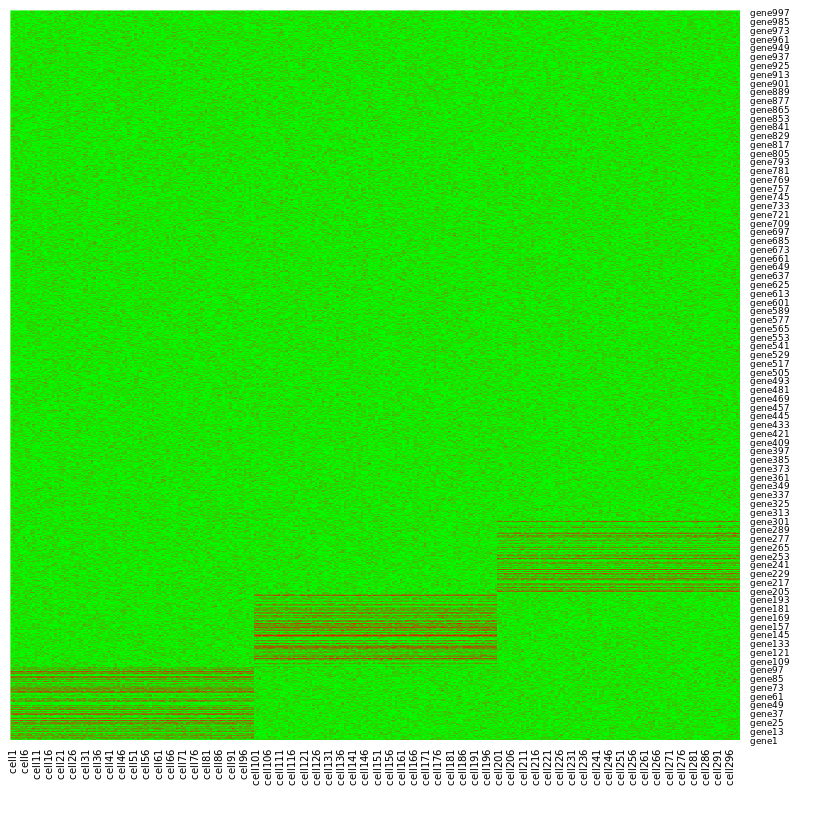

In [11]:
library(VAExprs)
    
### simulate differentially expressed genes
set.seed(1)
g <- 3
n <- 100
m <- 1000
mu <- 5
sigma <- 5
mat <- matrix(rnorm(n*m*g, mu, sigma), m, n*g)
rownames(mat) <- paste0("gene", seq_len(m))
colnames(mat) <- paste0("cell", seq_len(n*g))
group <- factor(sapply(seq_len(g), function(x) { 
    rep(paste0("group", x), n)
}))
names(group) <- colnames(mat)
mu_upreg <- 6
sigma_upreg <- 10
deg <- 100
for (i in seq_len(g)) {
    mat[(deg*(i-1) + 1):(deg*i), group == paste0("group", i)] <- 
        mat[1:deg, group==paste0("group", i)] + rnorm(deg, mu_upreg, sigma_upreg)
}
# positive expression only
mat[mat < 0] <- 0
x_train <- as.matrix(t(mat))
    
# heatmap
heatmap(mat, Rowv = NA, Colv = NA, 
        col = colorRampPalette(c('green', 'red'))(100), 
        scale = "none")

The VAE model can be built by using the function `fit_vae` with gene expression data and the cell annotation from the object `sce`. The overall loss function of the VAE is expressed as a weighted sum of the reconstruction loss and the regularization loss. The reconstruction loss is the binary cross-entropy loss between the input and output and the regularization loss is simply the Kullback-Leibler divergence measure. Note that the same dataset is used for training and validation.

In [12]:
## model parameters
batch_size <- 32
original_dim <- 1000
intermediate_dim <- 512
epochs <- 100

## VAE
vae_result <- fit_vae(x_train = x_train, x_val = x_train,
                      encoder_layers = list(layer_input(shape = c(original_dim)),
                                            layer_dense(units = intermediate_dim,
                                            activation = "relu")),
                      decoder_layers = list(layer_dense(units = intermediate_dim,
                                            activation = "relu"),
                                            layer_dense(units = original_dim,
                                            activation = "sigmoid")),
                      epochs = epochs, batch_size = batch_size,
                      use_generator = FALSE,
                      callbacks = keras::callback_early_stopping(
                                             monitor = "val_loss",
                                             patience = 10,
                                             restore_best_weights = TRUE))

normalizing...

training...




The function `plot_vae` draws the plot for model architecture.

In [13]:
## model architecture
plot_vae(vae_result$model)

HTML widgets cannot be represented in plain text (need html)

The function `gen_exprs` can generate samples with expression data by using the trained model.

generating...

post-processing...



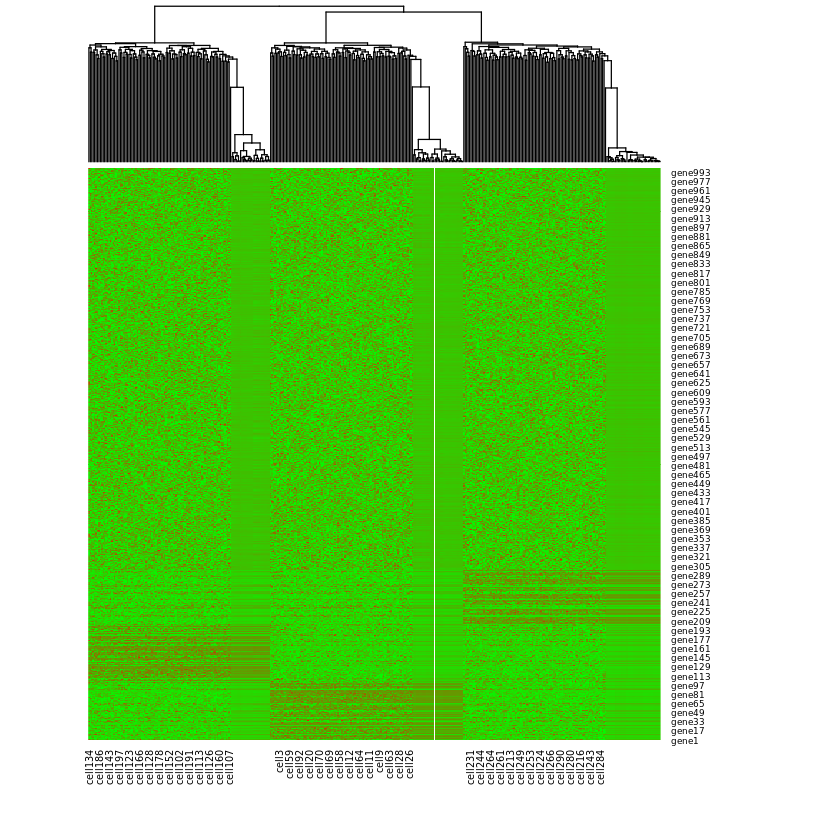

In [14]:
## sample generation
set.seed(1)
gen_sample_result <- gen_exprs(vae_result, num_samples = 100)
  
## heatmap
heatmap(cbind(t(x_train), t(gen_sample_result$x_gen)),
        col = colorRampPalette(c('green', 'red'))(100),
        Rowv=NA)

The function `plot_aug` uses reduced dimension plots for augmented data visualization.

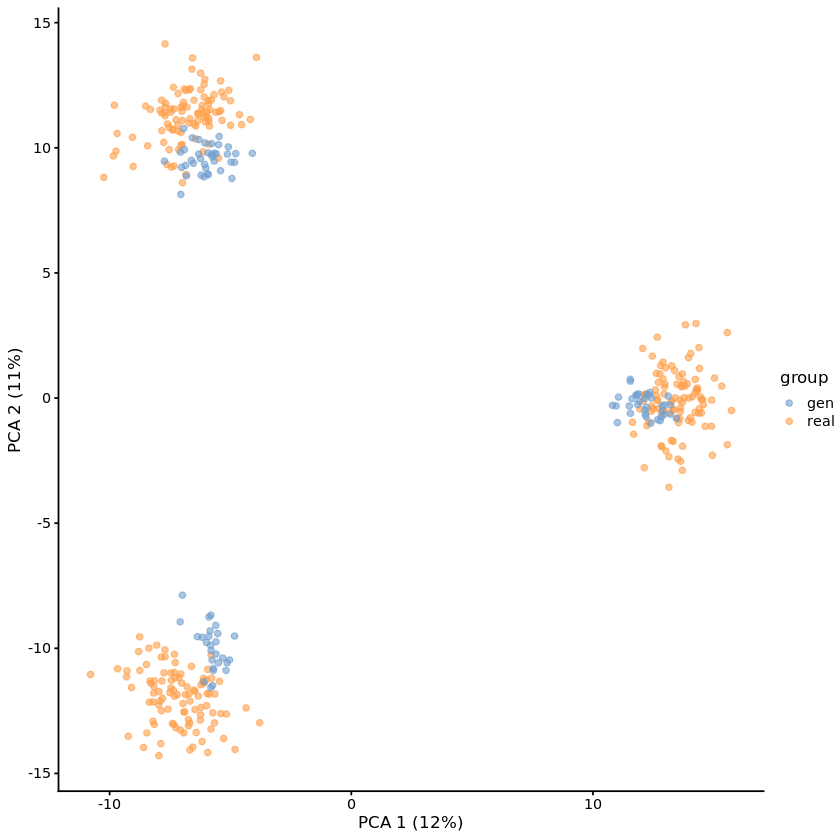

In [15]:
## plot for augmented data
plot_aug(gen_sample_result, "PCA")

### CVAE - Conditional Variational Autoencoder

The `yan` data set is single-cell RNA sequencing data with 20214 genes and 90 cells from human preimplantation embryos and embryonic stem cells at different passages. The rows in the dataset correspond to genes and columns correspond to cells. The `SingleCellExperiment` class can be used to store and manipulate single-cell genomics data. It extends the `RangedSummarizedExperiment` class and follows similar conventions. The object `sce` can be created by the data `yan` with cell type annotation `ann`.

In [16]:
library(SC3)
library(SingleCellExperiment)

## create a SingleCellExperiment object
sce <- SingleCellExperiment::SingleCellExperiment(
                                 assays = list(counts = as.matrix(yan)),
                                 colData = ann
    )

## define feature names in feature_symbol column
rowData(sce)$feature_symbol <- rownames(sce)
## remove features with duplicated names
sce <- sce[!duplicated(rowData(sce)$feature_symbol), ]
## remove genes that are not expressed in any samples
sce <- sce[which(rowMeans(assay(sce)) > 0),]
dim(assay(sce))

## model parameters
batch_size <- 32
original_dim <- 19595
intermediate_dim <- 256
epochs <- 100

## model
cvae_result <- fit_vae(object = sce,
                       encoder_layers = list(layer_input(shape = c(original_dim)),
                                             layer_dense(units = intermediate_dim,
                                                         activation = "relu")),
                       decoder_layers = list(layer_dense(units = intermediate_dim,
                                                         activation = "relu"),
                                             layer_dense(units = original_dim,
                                                         activation = "sigmoid")),
                       epochs = epochs, batch_size = batch_size,
                       use_generator = TRUE,
                       callbacks = keras::callback_early_stopping(
                            		      monitor = "loss",
                                              patience = 20,
                                              restore_best_weights = TRUE))


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

[1] 19595    90

pre-processing...

normalizing...

training...



In [17]:
## model architecture for CVAE
plot_vae(cvae_result$model)

HTML widgets cannot be represented in plain text (need html)

generating...

post-processing...



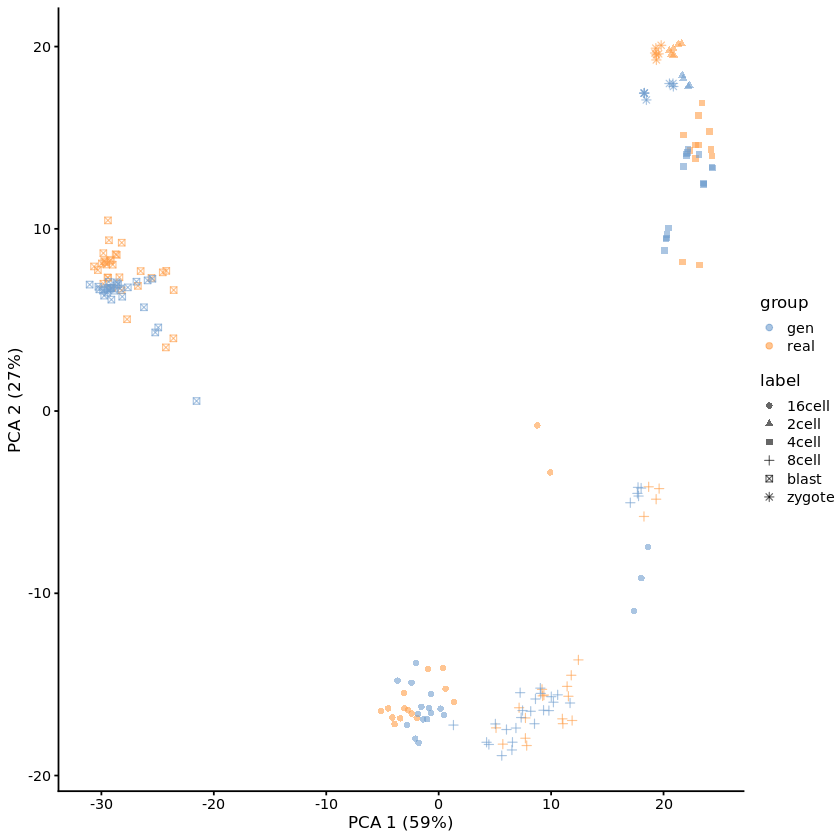

In [18]:
# sample generation
set.seed(1)
gen_sample_result <- gen_exprs(cvae_result, 100,
                               batch_size, use_generator = TRUE)
    
# plot for augmented data
plot_aug(gen_sample_result, "PCA")


### Session Information 

In [19]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SingleCellExperiment_1.16.0 SummarizedExperiment_1.24.0
 [3] Biobase_2.54.0              GenomicRanges_1.46.1       
 [5] GenomeInfoDb_1.30.1         IRanges_2.28.0             
 [7] S4Vectors_0.32.3            BiocGenerics_0.40.0     